<a href="https://colab.research.google.com/github/pSN0W/horse-vs-humans/blob/main/Horse_vs_human_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape = (150,150,3),
    include_top = False,
    weights = None
)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()



--2021-07-14 08:42:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   104MB/s    in 0.8s    

2021-07-14 08:42:49 (104 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0               

In [ ]:
last_layer = pre_trained_model.get_layer('mixed6')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 768)


In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024,activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1,activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2021-07-14 08:47:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  99.0MB/s    in 1.4s    

2021-07-14 08:47:39 (99.0 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2021-07-14 08:47:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 173.194.212.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [ ]:
train_horses_dir = 'tmp/training/horses'
train_humans_dir = 'tmp/training/humans'
validation_horses_dir = 'tmp/validation/horses'
validation_humans_dir = 'tmp/validation/horses'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_horses_dir)

print(len(train_horses_fnames))
print(train_humans_fnames)
print(validation_horses_dir)
print(validation_humans_dir)



In [ ]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.4,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale = 1/255.0 )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( 
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)



Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:


callbacks = myCallback()
history = model.fit(
    train_generator,
    steps_per_epoch = 51,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 12,
    callbacks = [callbacks]
)

Epoch 1/20
51/51 [==============================] - 73s 1s/step - loss: 0.1064 - accuracy: 0.9573 - val_loss: 0.0388 - val_accuracy: 0.9875
Epoch 2/20
51/51 [==============================] - 73s 1s/step - loss: 0.1384 - accuracy: 0.9682 - val_loss: 1.3893 - val_accuracy: 0.8208
Epoch 3/20
51/51 [==============================] - 72s 1s/step - loss: 0.1136 - accuracy: 0.9712 - val_loss: 0.8218 - val_accuracy: 0.8667
Epoch 4/20
51/51 [==============================] - 73s 1s/step - loss: 0.1283 - accuracy: 0.9732 - val_loss: 0.3170 - val_accuracy: 0.9375
Epoch 5/20
51/51 [==============================] - 74s 1s/step - loss: 0.0657 - accuracy: 0.9821 - val_loss: 0.2554 - val_accuracy: 0.9500
Epoch 6/20
51/51 [==============================] - 72s 1s/step - loss: 0.0907 - accuracy: 0.9821 - val_loss: 0.6507 - val_accuracy: 0.8875
Epoch 7/20
51/51 [==============================] - 73s 1s/step - loss: 0.0706 - accuracy: 0.9784 - val_loss: 1.4302 - val_accuracy: 0.8333
Epoch 8/20
51/51 [==

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 20,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 12,
    callbacks = [callbacks]
)

Epoch 1/20
20/20 [==============================] - 32s 2s/step - loss: 0.0288 - accuracy: 0.9900 - val_loss: 0.3714 - val_accuracy: 0.9542
Epoch 2/20
20/20 [==============================] - 32s 2s/step - loss: 0.0629 - accuracy: 0.9900 - val_loss: 0.0352 - val_accuracy: 0.9958
Epoch 3/20
20/20 [==============================] - 32s 2s/step - loss: 0.0635 - accuracy: 0.9825 - val_loss: 0.1149 - val_accuracy: 0.9875
Epoch 4/20
20/20 [==============================] - 31s 2s/step - loss: 7.4433e-04 - accuracy: 1.0000 - val_loss: 0.3067 - val_accuracy: 0.9667

Reached 99.9% accuracy so cancelling training!


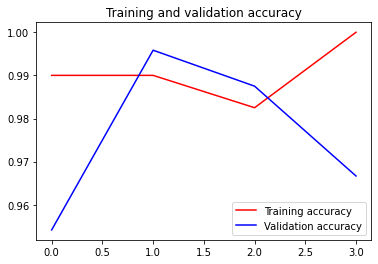

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()